In [1]:
# Imports
import numpy as np
import cv2
import os
import glob
import random
import time, datetime, sys
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

In [2]:
# Variables
dataset_size = 600
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor
nce_layers = [0, 4, 8, 12, 16]
lambda_NCE = 1.0
batch_size = 1
input_size = (3,216,384)
res_blocks = 9
load_weights = True
epoch = 0
epochs = 200

D_losses = []
GAN_losses = []
NCE_losses = []
G_total_losses = []


In [3]:
# Generate a basic dataset for full-frame translation

if not os.path.isdir('./dataset'):
    os.mkdir('./dataset')
    os.mkdir('./dataset/train')
    os.mkdir('./dataset/train/game')
    os.mkdir('./dataset/train/movie')
    os.mkdir('./dataset/test')
    os.mkdir('./dataset/test/game')
    os.mkdir('./dataset/test/movie')

    # get some frames from the game footage
    cap = cv2.VideoCapture('./Data/game/MafiaVideogame.mp4')
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_count = 0
    saved_frames = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame_count += 1
        if frame_count % (length // (2 * dataset_size)) == 0 and ret:
            #print(ret)
            if saved_frames % 2 == 0:
                fname = './dataset/train/game/' + str(saved_frames // 2) + '.png'
            else:
                fname = './dataset/test/game/' + str(saved_frames // 2) + '.png'
            cv2.imwrite(fname, frame)
            saved_frames += 1

    cap.release()

    # get some frames from the movie footage
    movie_dirs = ['./Data/movie/TheGodfather.mp4', './Data/movie/TheIrishman.mp4', './Data/movie/TheSopranos.mp4']

    saved_frames = 0
    for movie in movie_dirs:
        cap = cv2.VideoCapture(movie)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_count = 0

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1
            if frame_count % (length // (2 * dataset_size / len(movie_dirs))) == 0 and ret:
                if saved_frames % 2 == 0:
                    fname = './dataset/train/movie/' + str(saved_frames // 2) + '.png'
                else:
                    fname = './dataset/test/movie/' + str(saved_frames // 2) + '.png'
                cv2.imwrite(fname, frame)
                saved_frames += 1


        cap.release()
    

In [4]:
# Helpful class for loading both game and movie samples as one dataset
class ImageDataset(Dataset):
    def __init__(self, root, transforms_ = None, unaligned = False, mode = "train"):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_game = sorted(glob.glob(os.path.join(root, "%s/game" % mode) + "/*.*"))
        self.files_movie = sorted(glob.glob(os.path.join(root, "%s/movie" % mode) + "/*.*"))

    def __getitem__(self, index):
        image_game = Image.open(self.files_game[index % len(self.files_game)])

        if self.unaligned:
            image_movie = Image.open(self.files_movie[random.randint(0, len(self.files_movie) - 1)])
        else:
            image_movie = Image.open(self.files_movie[index % len(self.files_movie)])

        # Convert grayscale images to rgb
        if image_game.mode != "RGB":
            image_game = to_rgb(image_game)
        if image_movie.mode != "RGB":
            image_movie = to_rgb(image_movie)

        item_game = self.transform(image_game)
        item_movie = self.transform(image_movie)
        return {"game": item_game, "movie": item_movie}

    def __len__(self):
        return max(len(self.files_game), len(self.files_movie))

In [5]:
# Loading the dataset
# Define the dataset-wide transformations
transforms_ = [
    transforms.Resize(input_size[1], Image.BICUBIC),
    #transforms.RandomCrop((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]

# Training data loader
dataloader = DataLoader(
    ImageDataset('./dataset', transforms_ = transforms_, unaligned = True),
    batch_size = batch_size,
    shuffle = True,
    num_workers = 0,
)
# Test data loader
val_dataloader = DataLoader(
    ImageDataset('./dataset', transforms_ = transforms_, unaligned = True, mode = 'test'),
    batch_size = 5,
    shuffle = True,
    num_workers = 0,
)


In [6]:
# Other Utils

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
        
def sample_images(batches_done):
    """Saves a generated sample from the test set"""
    imgs = next(iter(val_dataloader))
    G.eval()
    real_A = Variable(imgs["game"].type(Tensor))
    fake_B = G(real_A)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B), 1)
    if not os.path.isdir('images'):
        os.mkdir('images')
    save_image(image_grid, "images/%s.png" % (batches_done), normalize=False)
    
class Normalize(nn.Module):
    def __init__(self, power=2):
        super(Normalize, self).__init__()
        self.power = power

    def forward(self, x):
        norm = x.pow(self.power).sum(1, keepdim=True).pow(1. / self.power)
        out = x.div(norm + 1e-7)
        return out


In [7]:
# Generator and Discriminator models adapted from https://github.com/eriklindernoren/PyTorch-GAN
# PatchSampleF adapted from https://github.com/taesungp/contrastive-unpaired-translation

class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(Generator, self).__init__()
        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [
            nn.ReflectionPad2d(channels), 
            nn.Conv2d(out_features, channels, 7), 
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x, layers = [], encode_only = False):
        if -1 in layers:
            layers.append(len(self.model))
        if len(layers) > 0:
            feat = x
            feats = []
            for layer_id, layer in enumerate(self.model):
                feat = layer(feat)
                if layer_id in layers:
                    feats.append(feat)
                else:
                    pass
                if layer_id == layers[-1] and encode_only:
                    return feats
            return feat, feats
        else:
            return self.model(x)
    
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()
        channels, height, width = input_shape
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize = True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)
    
class PatchSampleF(nn.Module):
    def __init__(self, use_mlp = True, init_type = 'normal', init_gain = 0.02, nc = 256):
        # potential issues: currently, we use the same patch_ids for multiple images in the batch
        super(PatchSampleF, self).__init__()
        self.l2norm = Normalize(2)
        self.use_mlp = use_mlp
        self.nc = nc  # hard-coded
        self.mlp_init = False
        self.init_type = init_type
        self.init_gain = init_gain

    def create_mlp(self, feats):
        for mlp_id, feat in enumerate(feats):
            input_nc = feat.shape[1]
            mlp = nn.Sequential(*[nn.Linear(input_nc, self.nc), nn.ReLU(), nn.Linear(self.nc, self.nc)])
            if torch.cuda.is_available():
                mlp.cuda()
            setattr(self, 'mlp_%d' % mlp_id, mlp)
        if torch.cuda.is_available():
            self.to(device)
        self.apply(weights_init_normal)
        self.mlp_init = True

    def forward(self, feats, num_patches = 64, patch_ids = None):
        return_ids = []
        return_feats = []
        if self.use_mlp and not self.mlp_init:
            self.create_mlp(feats)
        for feat_id, feat in enumerate(feats):
            B, H, W = feat.shape[0], feat.shape[2], feat.shape[3]
            feat_reshape = feat.permute(0, 2, 3, 1).flatten(1, 2)
            if num_patches > 0:
                if patch_ids is not None:
                    patch_id = patch_ids[feat_id]
                else:
                    patch_id = torch.randperm(feat_reshape.shape[1], device=feats[0].device)
                    patch_id = patch_id[:int(min(num_patches, patch_id.shape[0]))]  # .to(patch_ids.device)
                x_sample = feat_reshape[:, patch_id, :].flatten(0, 1)  # reshape(-1, x.shape[1])
            else:
                x_sample = feat_reshape
                patch_id = []
            if self.use_mlp:
                mlp = getattr(self, 'mlp_%d' % feat_id)
                x_sample = mlp(x_sample)
            return_ids.append(patch_id)
            x_sample = self.l2norm(x_sample)

            if num_patches == 0:
                x_sample = x_sample.permute(0, 2, 1).reshape([B, x_sample.shape[-1], H, W])
            return_feats.append(x_sample)
        return return_feats, return_ids

In [8]:
# Class to create separate losses for each feature, from https://github.com/taesungp/contrastive-unpaired-translation
class PatchNCELoss(nn.Module):
    def __init__(self, batch_size, nce_T = 0.07):
        super().__init__()
        self.batch_size = batch_size
        self.nce_T = nce_T
        self.cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        self.mask_dtype = torch.bool

    def forward(self, feat_q, feat_k):
        batchSize = feat_q.shape[0]
        dim = feat_q.shape[1]
        feat_k = feat_k.detach()

        # pos logit
        l_pos = torch.bmm(feat_q.view(batchSize, 1, -1), feat_k.view(batchSize, -1, 1))
        l_pos = l_pos.view(batchSize, 1)

        # neg logit

        # Should the negatives from the other samples of a minibatch be utilized?
        # In CUT and FastCUT, we found that it's best to only include negatives
        # from the same image. Therefore, we set
        # --nce_includes_all_negatives_from_minibatch as False
        # However, for single-image translation, the minibatch consists of
        # crops from the "same" high-resolution image.
        # Therefore, we will include the negatives from the entire minibatch.

        batch_dim_for_bmm = self.batch_size

        # reshape features to batch size
        feat_q = feat_q.view(batch_dim_for_bmm, -1, dim)
        feat_k = feat_k.view(batch_dim_for_bmm, -1, dim)
        npatches = feat_q.size(1)
        l_neg_curbatch = torch.bmm(feat_q, feat_k.transpose(2, 1))

        # diagonal entries are similarity between same features, and hence meaningless.
        # just fill the diagonal with very small number, which is exp(-10) and almost zero
        diagonal = torch.eye(npatches, device=feat_q.device, dtype=self.mask_dtype)[None, :, :]
        l_neg_curbatch.masked_fill_(diagonal, -10.0)
        l_neg = l_neg_curbatch.view(-1, npatches)

        out = torch.cat((l_pos, l_neg), dim=1) / self.nce_T

        loss = self.cross_entropy_loss(out, torch.zeros(out.size(0), dtype=torch.long,
                                                        device=feat_q.device))

        return loss

In [9]:
# Instantiate the networks, load the most recent saved models, and set the loss functions and optimizers

G = Generator(input_size, res_blocks).to(device)
D = Discriminator(input_size).to(device)
Sampler = PatchSampleF(batch_size).to(device)

criterion_GAN = torch.nn.MSELoss().to(device)
criterion_NCE = []

for nce_layer in nce_layers:
    criterion_NCE.append(PatchNCELoss(batch_size).to(device))

G.apply(weights_init_normal)
D.apply(weights_init_normal)

optimizer_G = torch.optim.Adam(G.parameters(), lr = 0.0002, betas = (0.5, 0.999))
optimizer_D = torch.optim.Adam(D.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [10]:
# Parameters for the sampler are not made until the first forward pass through the Sampler network
# Hence, we do a 'trial' training pass before setting the optimizer for the Sampler
for i, batch in enumerate(dataloader):
    x, y = Variable(batch["game"].type(Tensor)), Variable(batch["movie"].type(Tensor))
    
    real = Variable(Tensor(np.ones((x.size(0), *D.output_shape))), requires_grad = False)
    fake = Variable(Tensor(np.zeros((x.size(0), *D.output_shape))), requires_grad = False)
    
    # get the fake loss
    fake_y = G(x)
    D_fake = D(fake_y.detach())
    loss_D_fake = criterion_GAN(D_fake, fake).mean()
    # get the real loss
    D_real = D(y)
    loss_D_real = criterion_GAN(D_real, real).mean()
    # combine loss and calculate gradients
    loss_D = (loss_D_fake + loss_D_real) * 0.5
    loss_D.backward()

    # get the fake GAN loss
    D_fake = D(fake_y)
    loss_G_GAN = criterion_GAN(D_fake, real).mean()
    total_nce_loss = 0
    for fake, real in [(fake_y, x), (y, G(y))]:
        # get the NCE loss
        feat_q = G(fake, nce_layers, encode_only = True)
        feat_k = G(real, nce_layers, encode_only = True)

        feat_k_pool, sample_ids = Sampler(feat_k, 256, None)
        feat_q_pool, _ = Sampler(feat_q, 256, sample_ids)

        total_nce_loss = 0.0
        for f_q, f_k, crit, nce_layer in zip(feat_q_pool, feat_k_pool, criterion_NCE, nce_layers):
            loss = crit(f_q, f_k) * lambda_NCE
            total_nce_loss += loss.mean()

        nce_loss = total_nce_loss / len(nce_layers)
        total_nce_loss += nce_loss

    loss_G = loss_G_GAN + total_nce_loss
    loss_G.backward()
    
    break

optimizer_Sampler = torch.optim.Adam(Sampler.parameters(), lr = 0.0002, betas = (0.5, 0.999))

In [11]:
# Load the most recently saved models if available
if os.path.isdir('saved_models') and load_weights:
    # Get the most recent model and load them
    epoch = max([int(fname[8:-4]) for fname in os.listdir('saved_models') if 'Sampler' in fname])
    G.load_state_dict(torch.load('saved_models/G_%d.pth' % (epoch)))
    D.load_state_dict(torch.load('saved_models/D_%d.pth' % (epoch)))
    Sampler.load_state_dict(torch.load('saved_models/Sampler_%d.pth' % (epoch)))
    # Load the losses as well, for plotting
    losses = np.load('saved_models/losses_%d.npy' % (epoch))
    D_losses = list(losses[0])
    GAN_losses = list(losses[1])
    NCE_losses = list(losses[2])
    G_total_losses = list(losses[3])

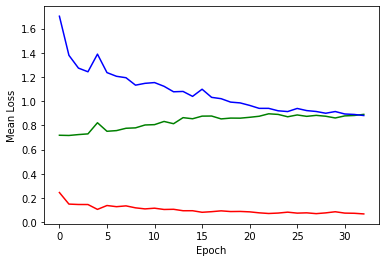

[Epoch 32/200] [Batch 485/602] [D loss: 0.014287] [GAN loss: 1.146085, NCE loss: 0.720480, Total: 5.468964] ETA: 1 day, 14:21:57.9348632

In [ ]:
# Training Loop, adapted from https://github.com/taesungp/contrastive-unpaired-translation

prev_time = time.time()
for epoch in range(epoch, epochs):
    total_D_loss = 0
    total_GAN_loss = 0
    total_NCE_loss = 0
    total_G_loss = 0
    for i, batch in enumerate(dataloader):
        x, y = Variable(batch["game"].type(Tensor)), Variable(batch["movie"].type(Tensor))
        
        # Adversarial ground truths
        real = Variable(Tensor(np.ones((x.size(0), *D.output_shape))), requires_grad = False)
        fake = Variable(Tensor(np.zeros((x.size(0), *D.output_shape))), requires_grad = False)
        
        # train discriminator
        D.train()
        optimizer_D.zero_grad()
        # get the fake loss
        fake_y = G(x)
        D_fake = D(fake_y.detach())
        loss_D_fake = criterion_GAN(D_fake, fake).mean()
        # get the real loss
        D_real = D(y)
        loss_D_real = criterion_GAN(D_real, real).mean()
        # combine loss and calculate gradients
        loss_D = (loss_D_fake + loss_D_real) * 0.5
        loss_D.backward()
        optimizer_D.step()
        
        # train generator
        G.train()
        optimizer_G.zero_grad()
        optimizer_Sampler.zero_grad()
        # get the fake GAN loss
        D_fake = D(fake_y)
        loss_G_GAN = criterion_GAN(D_fake, real).mean()
        # get the NCE loss
        total_nce_loss = 0
        for fake, real in [(fake_y, x), (y, G(y))]:
            feat_q = G(fake_y, nce_layers, encode_only = True)
            feat_k = G(x, nce_layers, encode_only = True)

            feat_k_pool, sample_ids = Sampler(feat_k, 256, None)
            feat_q_pool, _ = Sampler(feat_q, 256, sample_ids)

            total_nce_loss = 0.0
            for f_q, f_k, crit, nce_layer in zip(feat_q_pool, feat_k_pool, criterion_NCE, nce_layers):
                loss = crit(f_q, f_k) * lambda_NCE
                total_nce_loss += loss.mean()

            nce_loss = total_nce_loss / len(nce_layers)
            total_nce_loss += nce_loss
        
        loss_G = loss_G_GAN + total_nce_loss
        loss_G.backward()
        optimizer_G.step()
        optimizer_Sampler.step()
        
        # --------------
        #  Log Progress
        # --------------

        # Determine approximate time left
        batches_done = epoch * len(dataloader) + i
        batches_left = 200 * len(dataloader) - batches_done
        time_left = datetime.timedelta(seconds=batches_left * (time.time() - prev_time))
        prev_time = time.time()

        # Print log
        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [GAN loss: %f, NCE loss: %f, Total: %f] ETA: %s"
            % (
                epoch,
                200,
                i,
                len(dataloader),
                loss_D.item(),
                loss_G_GAN.item(),
                nce_loss.item(),
                loss_G.item(),
                time_left,
            )
        )
        
        total_D_loss += loss_D.item()
        total_GAN_loss += loss_G_GAN.item()
        total_NCE_loss += nce_loss.item()
        total_G_loss += loss_G.item()
        
        # If at sample interval save image
        if batches_done % 300 == 0:
            sample_images(batches_done)
            
    D_losses.append(total_D_loss / len(dataloader))
    GAN_losses.append(total_GAN_loss / len(dataloader))
    NCE_losses.append(total_NCE_loss / len(dataloader))
    G_total_losses.append(total_G_loss / len(dataloader))
    display.clear_output(wait = True)
    time.sleep(1)
    plt.clf()
    plt.ylabel('Mean Loss')
    plt.xlabel('Epoch')
    plt.plot(D_losses, color = 'r')
    plt.plot(GAN_losses, color = 'g')
    plt.plot(NCE_losses, color = 'b')
    display.display(plt.gcf())
    
    if epoch % 5 == 0:
        if not os.path.isdir('saved_models'):
            os.mkdir('saved_models')
        torch.save(G.state_dict(), "saved_models/G_%d.pth" % (epoch))
        torch.save(D.state_dict(), "saved_models/D_%d.pth" % (epoch))
        torch.save(Sampler.state_dict(), "saved_models/Sampler_%d.pth" % (epoch))
        np.save('saved_models/losses_%d.npy' % (epoch), np.array([D_losses, GAN_losses, NCE_losses, G_total_losses]))
    
    